In [1]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from numpy import *
from shutil import copyfile
pretrained = False
background = False

# Custom Triplet Dataset class
Each time will give a tuple of anchor image, postive image and negative image

In [26]:
class SiameseNetworkDataset_triplet(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            img1_tuple = random.choice(self.imageFolderDataset.imgs)

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

# Create training and test sets using CASIA dataset

In [41]:
import os
import shutil
if not pretrained:
    training_dir = "/home/shared/CS341/Siamese/Facial-Similarity-with-Siamese-Networks-in-Pytorch/CS341/"
    testing_dir = "/home/shared/CS341/Siamese/Facial-Similarity-with-Siamese-Networks-in-Pytorch/test/"
    for file in os.listdir(training_dir):
        if (random.random() > 0.85):
            shutil.move(os.path.join(training_dir, file), os.path.join(testing_dir, file))
folder_dataset_CASIA = dset.ImageFolder("/home/shared/CS341/Siamese/Facial-Similarity-with-Siamese-Networks-in-Pytorch/CS341/") 

# Visuallize images of one batch

/home/shared/anaconda3/lib/python3.6/site-packages/torchvision/transforms/transforms.py:188: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


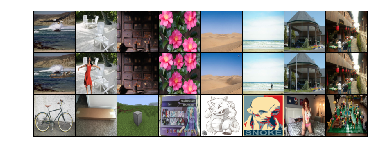

In [45]:
siamese_dataset = SiameseNetworkDataset_triplet(imageFolderDataset_main=folder_dataset,
                                                transform=transforms.Compose([transforms.Scale((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=8)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1], example_batch[2]))
imshow(torchvision.utils.make_grid(concatenated))

# Triplet Architecture and Contrastive loss function for triplet

In [46]:
class SiameseNetwork_Hamming(nn.Module):
    def __init__(self):
        super(SiameseNetwork_Hamming, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(3, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),

            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5)
        )

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2, input3):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        output3 = self.forward_once(input3)
        return output1, output2, output3

class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, output3):
        similar_distance = F.pairwise_distance(output1, output2)
        dissimilar_distance = F.pairwise_distance(output1, output3)
        loss_contrastive = torch.mean(torch.pow(similar_distance, 2) +
                                      torch.pow(torch.clamp(self.margin - dissimilar_distance, min=0.0), 2))

        return loss_contrastive

# Training time

/home/shared/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/shared/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch number 0
 Current loss 3.47921085357666

Epoch number 0
 Current loss 0.17870526015758514

Epoch number 0
 Current loss 0.5024362206459045

Epoch number 0
 Current loss 0.21625976264476776

Epoch number 1
 Current loss 0.5012357234954834

Epoch number 1
 Current loss 0.046091075986623764

Epoch number 1
 Current loss 0.1653042882680893

Epoch number 1
 Current loss 0.11137014627456665

Epoch number 2
 Current loss 1.1091716289520264

Epoch number 2
 Current loss 0.028802191838622093

Epoch number 2
 Current loss 0.08507423847913742

Epoch number 2
 Current loss 0.10497958958148956

Epoch number 3
 Current loss 0.3896450996398926

Epoch number 3
 Current loss 0.016641534864902496

Epoch number 3
 Current loss 0.03806016966700554

Epoch number 3
 Current loss 0.06824615597724915

Epoch number 4
 Current loss 0.25863149762153625

Epoch number 4
 Current loss 0.008139587938785553

Epoch number 4
 Current loss 0.07300252467393875

Epoch number 4
 Current loss 0.09118940681219101

Epoc

Epoch number 39
 Current loss 0.007111128885298967

Epoch number 40
 Current loss 0.016818620264530182

Epoch number 40
 Current loss 0.0014094694051891565

Epoch number 40
 Current loss 0.001174161909148097

Epoch number 40
 Current loss 0.0076795900240540504

Epoch number 41
 Current loss 0.015949085354804993

Epoch number 41
 Current loss 0.002585666486993432

Epoch number 41
 Current loss 0.001281607081182301

Epoch number 41
 Current loss 0.0034431936219334602

Epoch number 42
 Current loss 0.010293971747159958

Epoch number 42
 Current loss 0.002750230021774769

Epoch number 42
 Current loss 0.0005858218646608293

Epoch number 42
 Current loss 0.002173501765355468

Epoch number 43
 Current loss 0.013659478165209293

Epoch number 43
 Current loss 0.0030833478085696697

Epoch number 43
 Current loss 0.0009454390965402126

Epoch number 43
 Current loss 0.002954852534458041

Epoch number 44
 Current loss 0.010135975666344166

Epoch number 44
 Current loss 0.0010621236870065331

Epoch

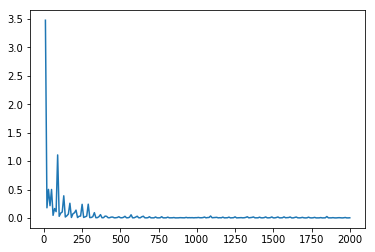

In [47]:
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=32)

net = SiameseNetwork_Hamming().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.0005 )

counter = []
loss_history = [] 
iteration_number= 0

for epoch in range(0,50):
    for i, data in enumerate(train_dataloader,0):
        img0, img1 , img2 = data
        img0, img1 , img2 = Variable(img0).cuda(), Variable(img1).cuda(), Variable(img2).cuda()
        output1,output2,output3 = net(img0,img1,img2)
        optimizer.zero_grad()
        loss_contrastive = criterion(output1,output2,output3)
        loss_contrastive.backward()
        optimizer.step()
        if i %50 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.data[0]))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.data[0])
show_plot(counter,loss_history)

# Load pre-trained model based on Reddit training data (Pre-trained Reddit)

In [ ]:
import os
if pretrained:
    net = SiameseNetwork_Hamming().cuda()
    if os.path.exists('pretrained_newtest.pkl'):
        checkpoint = torch.load('pretrained_newtest.pkl')
        net.load_state_dict(checkpoint)
        print("loaded")

# Load CASIA test dataset

In [59]:
folder_dataset = dset.ImageFolder(root=testing_dir)
len(folder_dataset.imgs)

981

# Retrieve encodings of CASIA test images using trained model (only CASIA)

In [53]:
image_tuples = {}
encodings = None
index = 0
nums = {}
for x in range(276): 
    nums[x] = 0
transform=transforms.Compose([transforms.Scale((100,100)),transforms.ToTensor()])
for img in folder_dataset.imgs:
    label = img[1]
    nums[label] += 1
    img = Image.open(img[0])
    img = img.convert("RGB")
    img = transform(img).view(1,3,100,100)
    encoding = net.forward_once(Variable(img).cuda())
    image_tuples[index] = label
    index += 1
    if (encodings is None):
        encodings = list([encoding.data.cpu().numpy()[0]])
    else:
        encodings.append(encoding.data.cpu().numpy()[0])

/home/shared/anaconda3/lib/python3.6/site-packages/torchvision/transforms/transforms.py:188: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")
/home/shared/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:739: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 2. Skipping tag 41487
  " Skipping tag %s" % (size, len(data), tag))
/home/shared/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:739: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 41988
  " Skipping tag %s" % (size, len(data), tag))


# Extract and add feature vectors of training images to the test set as background (CASIA + background)

In [54]:
background = False
if background:
    folder_dataset = dset.ImageFolder("/home/shared/CS341/Dataprocessing/train")
    for img in folder_dataset.imgs:
        img = Image.open(img[0])
        img = img.convert("RGB")
        img = transform(img).view(1,3,100,100)
        encoding = net.forward_once(Variable(img).cuda())
        if (encodings is None):
            encodings = list([encoding.data.cpu().numpy()[0]])
        else:
            encodings.append(encoding.data.cpu().numpy()[0])

/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:918: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2514: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


In [2]:
# encodings = np.array(encodings)
# encodings.shape

# Perform Image ranking for each of the images in CASIA test set

In [60]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
nbrs = NearestNeighbors(n_neighbors=981, algorithm='ball_tree').fit(encodings)
distances, indices = nbrs.kneighbors(encodings[0:981])

In [61]:
result = np.ones((981,981))
for i in range(981):
    for j in range(981):
        try:
            result[i][j] = image_tuples[indices[i][j]]
        except:
            pass

# Calulate top k accuracy
In this case, k = 2

In [95]:
count = 0
k = 2
for i in range(981):
    if(result[i][0] in result[i][1:k+1]):
        count+= 1

In [96]:
count/981

0.8817533129459735

# MRR Calculation

In [ ]:
recip = 0
count = 0
for i in range(981):
    for j in range(1, 981):
        if(result[i][j] == result[i][0]):
            recip += 1/j
            count += 1

In [ ]:
recip/count